In [42]:
import os
import re
import string
import time
import random
import unicodedata
import tokenizers
from pathlib import Path
from typing import List, Tuple, Dict
from collections import Counter
import torch
from torch.utils.data import Dataset, DataLoader, random_split, Sampler
import matplotlib.pyplot as plt
import numpy as np
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from tqdm.auto import tqdm
genai = None

os.environ["TOKENIZERS_PARALLELISM"] = "false"

max_seq_len = 128

In [43]:
def read_data(file_path: str) -> List[str]:
    """Đọc file txt và trả về list sentences (theo lines để giữ parallel)."""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File {file_path} không tồn tại. Tải từ VLSP hoặc IWSLT.")
    
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = [line.strip() for line in f if line.strip() and not line.startswith('(truncated')]
    
    return lines


print("Đang đọc dữ liệu...")
train_src = read_data('/kaggle/input/vie-eng/train.vi.txt')
train_tgt = read_data('/kaggle/input/vie-eng/train.en.txt')
test_src = read_data('/kaggle/input/vie-eng/public_test.vi.txt')
test_tgt = read_data('/kaggle/input/vie-eng/public_test.en.txt') 

if len(train_src) != len(train_tgt):
    raise ValueError(f"❌ Train không khớp! Vi: {len(train_src)}, En: {len(train_tgt)}")
if len(test_src) != len(test_tgt):
    raise ValueError(f"❌ Test không khớp! Vi: {len(test_src)}, En: {len(test_tgt)}")
print(f"✅ Dữ liệu đọc thành công! Số câu train: {len(train_src)}, số câu test: {len(test_src)}")


# Báo cáo thống kê
print(f"✅ Train: {len(train_src)} pairs")
print(f"✅ Test: {len(test_src)} pairs")
print(f"Ví dụ Vi: {train_src[0][:100]}...")
print(f"Ví dụ En: {train_tgt[0][:100]}...")

Đang đọc dữ liệu...
✅ Dữ liệu đọc thành công! Số câu train: 500000, số câu test: 3000
✅ Train: 500000 pairs
✅ Test: 3000 pairs
Ví dụ Vi: Nghiên cứu đặc điểm lâm sàng, cận lâm sàng bệnh nhân viêm tai ứ dịch trên viêm V.A tại Khoa Tai mũi ...
Ví dụ En: To evaluate clinical, subclinical symptoms of patients with otitis media with effusion and V.a at ot...


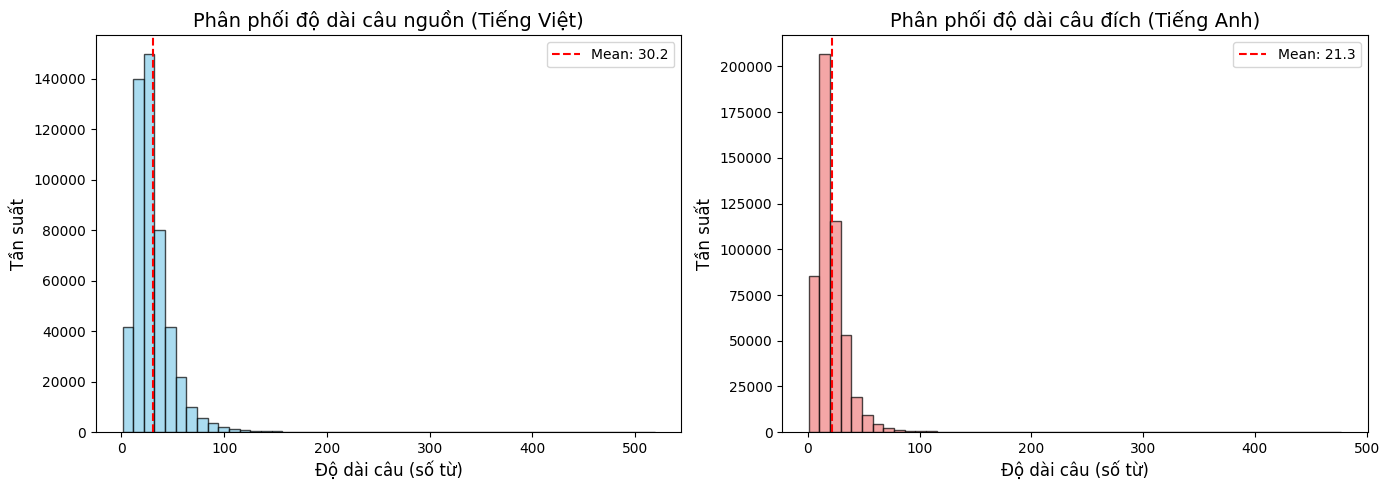

Min/Max src: 1/519
Min/Max tgt: 1/477


In [44]:
# Phân tích độ dài câu gốc (trước khi clean)
src_lengths = [len(s.split()) for s in train_src]
tgt_lengths = [len(t.split()) for t in train_tgt]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram cho source (Vietnamese)
axes[0].hist(src_lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Độ dài câu (số từ)', fontsize=12)
axes[0].set_ylabel('Tần suất', fontsize=12)
axes[0].set_title('Phân phối độ dài câu nguồn (Tiếng Việt)', fontsize=14)
axes[0].axvline(x=sum(src_lengths)/len(src_lengths), color='red', linestyle='--', label=f'Mean: {sum(src_lengths)/len(src_lengths):.1f}')
axes[0].legend()

# Histogram cho target (English)
axes[1].hist(tgt_lengths, bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Độ dài câu (số từ)', fontsize=12)
axes[1].set_ylabel('Tần suất', fontsize=12)
axes[1].set_title('Phân phối độ dài câu đích (Tiếng Anh)', fontsize=14)
axes[1].axvline(x=sum(tgt_lengths)/len(tgt_lengths), color='red', linestyle='--', label=f'Mean: {sum(tgt_lengths)/len(tgt_lengths):.1f}')
axes[1].legend()

plt.tight_layout()
plt.savefig('length_distribution_raw.png', dpi=150)
plt.show()

print(f"Min/Max src: {min(src_lengths)}/{max(src_lengths)}")
print(f"Min/Max tgt: {min(tgt_lengths)}/{max(tgt_lengths)}")

In [45]:
def clean_sentence(sentence: str, lowercase: bool = True, preserve_punct: str = ".,:;/%-+()[]{}") -> str:
    if sentence is None:
        return ""

    # 1) Normalize unicode
    s = unicodedata.normalize('NFC', sentence)

    # 2) Replace smart quotes and nonstandard dashes with ASCII equivalents
    s = s.replace('“', '"').replace('”', '"').replace('‘', "'").replace('’', "'")
    s = s.replace('—', '-').replace('–', '-').replace('−', '-')

    # 3) Remove control characters
    s = ''.join(ch for ch in s if unicodedata.category(ch)[0] != 'C')

    # 4) Optionally lowercase
    if lowercase:
        s = s.lower()

    # 5) Remove unwanted punctuation but keep preserve_punct
    # Build set of punctuation to remove
    all_punct = set(string.punctuation)
    keep = set(preserve_punct)
    remove = ''.join(sorted(all_punct - keep))
    if remove:
        s = s.translate(str.maketrans('', '', remove))

    # 6) Normalize whitespace
    s = re.sub(r'\s+', ' ', s).strip()

    # 7) Remove stray leading/trailing punctuation
    s = s.strip(" ".join(["'", '"', ".", ",", "-", ":", ";"]))

    return s

# Tạo pairs và clean
train_pairs_raw = list(zip(train_src, train_tgt))
test_pairs_raw = list(zip(test_src, test_tgt))
train_pairs = [(clean_sentence(src), clean_sentence(tgt)) for src, tgt in zip(train_src, train_tgt)]
test_pairs = [(clean_sentence(src), clean_sentence(tgt)) for src, tgt in zip(test_src, test_tgt)]

# Lọc sentences: min_len=3 words, max_len=100 words
min_len, max_len = 3, 100
train_pairs_filtered = [
    (src, tgt) for src, tgt in train_pairs
    if min_len <= len(src.split()) <= max_len 
    and min_len <= len(tgt.split()) <= max_len
]

test_pairs_filtered = [
    (src, tgt) for src, tgt in test_pairs
    if min_len <= len(src.split()) <= max_len 
    and min_len <= len(tgt.split()) <= max_len
]

train_pairs_filtered = list(dict.fromkeys(train_pairs_filtered))
test_pairs_filtered = list(dict.fromkeys(test_pairs_filtered))
# Báo cáo
print(f"\n📊 Sau khi lọc:")
print(f"   Train: {len(train_pairs_raw)} → {len(train_pairs_filtered)} pairs")
print(f"   Test: {len(test_pairs_raw)} → {len(test_pairs_filtered)} pairs")
print(f"   Loại bỏ: {len(train_pairs_raw) - len(train_pairs_filtered)} train pairs")


📊 Sau khi lọc:
   Train: 500000 → 343110 pairs
   Test: 3000 → 2976 pairs
   Loại bỏ: 156890 train pairs


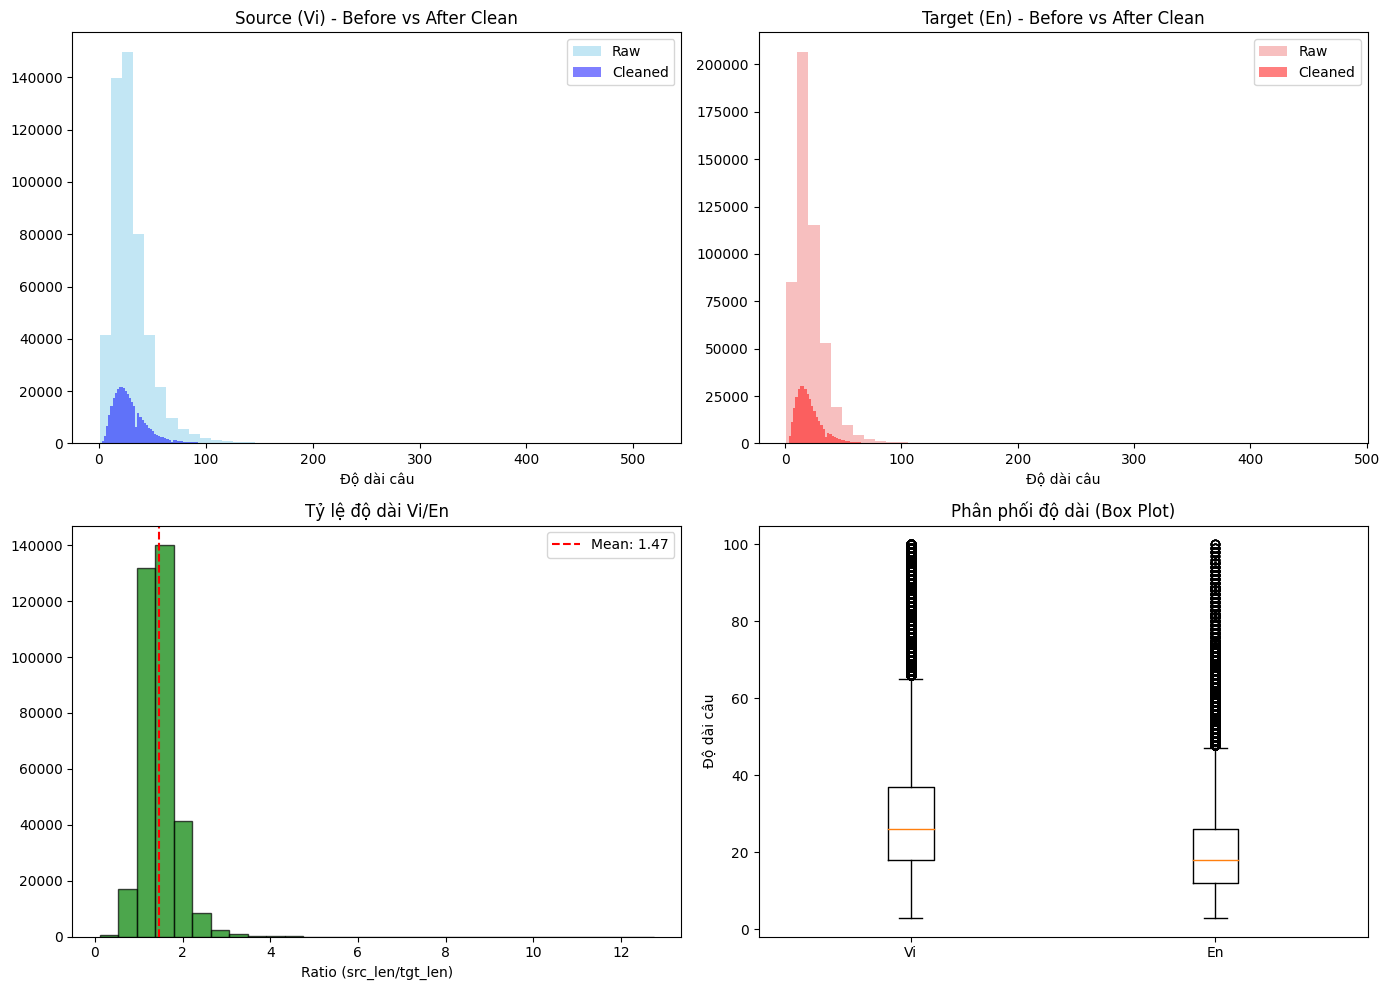

Số câu bị loại: 0 (0.0%)


In [46]:
# Phân phối sau khi clean và filter
src_lengths_clean = [len(s.split()) for s, _ in train_pairs_filtered]
tgt_lengths_clean = [len(t.split()) for _, t in train_pairs_filtered]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# So sánh source
axes[0, 0].hist(src_lengths, bins=50, color='skyblue', alpha=0.5, label='Raw')
axes[0, 0].hist(src_lengths_clean, bins=50, color='blue', alpha=0.5, label='Cleaned')
axes[0, 0].set_title('Source (Vi) - Before vs After Clean')
axes[0, 0].legend()
axes[0, 0].set_xlabel('Độ dài câu')

# So sánh target
axes[0, 1].hist(tgt_lengths, bins=50, color='lightcoral', alpha=0.5, label='Raw')
axes[0, 1].hist(tgt_lengths_clean, bins=50, color='red', alpha=0.5, label='Cleaned')
axes[0, 1].set_title('Target (En) - Before vs After Clean')
axes[0, 1].legend()
axes[0, 1].set_xlabel('Độ dài câu')

# Tỷ lệ độ dài src/tgt
length_ratios = [len(s.split())/len(t.split()) for s, t in train_pairs_filtered]
axes[1, 0].hist(length_ratios, bins=30, color='green', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Tỷ lệ độ dài Vi/En')
axes[1, 0].set_xlabel('Ratio (src_len/tgt_len)')
axes[1, 0].axvline(x=sum(length_ratios)/len(length_ratios), color='red', linestyle='--', 
                    label=f'Mean: {sum(length_ratios)/len(length_ratios):.2f}')
axes[1, 0].legend()

# Box plot so sánh
axes[1, 1].boxplot([src_lengths_clean, tgt_lengths_clean], labels=['Vi', 'En'])
axes[1, 1].set_title('Phân phối độ dài (Box Plot)')
axes[1, 1].set_ylabel('Độ dài câu')

plt.tight_layout()
plt.savefig('length_distribution_cleaned.png', dpi=150)
plt.show()

print(f"Số câu bị loại: {len(train_src) - len(train_pairs)} ({100*(len(train_src)-len(train_pairs))/len(train_src):.1f}%)")

In [47]:
def tokenize(sentence: str) -> List[str]:
    """Tokenize: split words, thêm <SOS> và <EOS>."""
    tokens = sentence.split()
    return ['<SOS>'] + tokens + ['<EOS>']

# Tokenize tất cả
train_src_tokens = [tokenize(src) for src, _ in train_pairs_filtered]
train_tgt_tokens = [tokenize(tgt) for _, tgt in train_pairs_filtered]
test_src_tokens = [tokenize(src) for src, _ in test_pairs_filtered]
test_tgt_tokens = [tokenize(tgt) for _, tgt in test_pairs_filtered]

In [48]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

def train_bpe_tokenizer(sentences, vocab_size=32000):
    # 1. Initialize
    tokenizer = Tokenizer(BPE(unk_token="<UNK>"))
    tokenizer.pre_tokenizer = Whitespace()
    
    # 2. Configure Trainer
    # Ensure these special tokens match exactly what your model expects
    trainer = BpeTrainer(
        special_tokens=["<PAD>", "<UNK>", "<SOS>", "<EOS>"], 
        vocab_size=vocab_size, 
        min_frequency=2
    )
    
    # 3. Train
    # Note: tokenizers expects an iterator of strings
    tokenizer.train_from_iterator(sentences, trainer)
    return tokenizer

print("Training Source (Vi) Tokenizer...")
src_tokenizer = train_bpe_tokenizer(train_src, vocab_size=30000)

print("Training Target (En) Tokenizer...")
tgt_tokenizer = train_bpe_tokenizer(train_tgt, vocab_size=30000)

print("Tokenizers trained!")
print(f"Src Vocab Size: {src_tokenizer.get_vocab_size()}")
print(f"Tgt Vocab Size: {tgt_tokenizer.get_vocab_size()}")

⏳ Training Source (Vi) Tokenizer...



⏳ Training Target (En) Tokenizer...



✅ Tokenizers trained!
Src Vocab Size: 30000
Tgt Vocab Size: 30000


In [49]:
import torch
import math
import random
from torch.utils.data import Dataset, Sampler, DataLoader, random_split

use_cuda = torch.cuda.is_available()

class TranslationDataset(Dataset):
    def __init__(self, src_indices: torch.Tensor, tgt_indices: torch.Tensor):
        self.src = src_indices
        self.tgt = tgt_indices
    
    def __len__(self):
        return len(self.src)
    
    def __getitem__(self, idx):
        return self.src[idx], self.tgt[idx]


class BucketBatchSampler(Sampler[List[int]]):
    def __init__(
        self,
        lengths: List[int],
        batch_size: int,
        bucket_size_multiplier: int = 100,
        shuffle: bool = True,
        drop_last: bool = False,
        seed: int = 42,
    ):
        self.lengths = lengths
        self.batch_size = batch_size
        self.bucket_size = batch_size * bucket_size_multiplier
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.seed = seed

    def __iter__(self):
        indices = list(range(len(self.lengths)))
        rng = random.Random(self.seed)
        if self.shuffle:
            rng.shuffle(indices)
        for bucket_start in range(0, len(indices), self.bucket_size):
            bucket = indices[bucket_start:bucket_start + self.bucket_size]
            bucket.sort(key=lambda idx: self.lengths[idx])
            for batch_start in range(0, len(bucket), self.batch_size):
                batch = bucket[batch_start:batch_start + self.batch_size]
                if len(batch) < self.batch_size and self.drop_last:
                    continue
                yield batch
        if self.shuffle:
            self.seed = rng.randint(0, 1_000_000_000)

    def __len__(self) -> int:
        total = len(self.lengths)
        if self.drop_last:
            return total // self.batch_size
        return math.ceil(total / self.batch_size)


def build_dataloader(dataset: TranslationDataset, lengths: List[int], batch_size: int, shuffle: bool = True) -> DataLoader:
    sampler = BucketBatchSampler(lengths, batch_size=batch_size, shuffle=shuffle)
    return DataLoader(
        dataset,
        batch_sampler=sampler,
        pin_memory=use_cuda,
        num_workers=4,
    )

In [50]:
src_pad_id = src_tokenizer.token_to_id("<PAD>")
tgt_pad_id = tgt_tokenizer.token_to_id("<PAD>")
src_pad_idx = src_pad_id
tgt_pad_idx = tgt_pad_id
sos_idx = tgt_tokenizer.token_to_id("<SOS>")
eos_idx = tgt_tokenizer.token_to_id("<EOS>")

val_ratio = 0.1
batch_size = 32

# 1. Define Encoding Function using BPE
def encode_with_bpe(tokenizer, sentences, max_len=128):
    sos_id = tokenizer.token_to_id("<SOS>")
    eos_id = tokenizer.token_to_id("<EOS>")
    pad_id = tokenizer.token_to_id("<PAD>")
    
    indices_list = []
    # Using batch encode is significantly faster
    encoded_batch = tokenizer.encode_batch(sentences)
    
    for enc in encoded_batch:
        ids = enc.ids
        # Truncate if too long (reserving 2 spots for SOS/EOS)
        if len(ids) > max_len - 2:
            ids = ids[:max_len - 2]
        
        # Wrap with special tokens
        ids = [sos_id] + ids + [eos_id]
        indices_list.append(torch.tensor(ids, dtype=torch.long))
    
    # Pad sequences
    padded = torch.nn.utils.rnn.pad_sequence(indices_list, batch_first=True, padding_value=pad_id)
    return padded

print("Encoding Data with BPE...")
# 2. Overwrite tensors with BPE data
train_src_indices = encode_with_bpe(src_tokenizer, train_src, max_len=max_seq_len)
train_tgt_indices = encode_with_bpe(tgt_tokenizer, train_tgt, max_len=max_seq_len)
test_src_indices  = encode_with_bpe(src_tokenizer, test_src,  max_len=max_seq_len)
test_tgt_indices  = encode_with_bpe(tgt_tokenizer, test_tgt,  max_len=max_seq_len)

# 3. Recalculate lengths for BucketBatchSampler (Critical for efficiency)
# We calculate lengths based on non-padding tokens
src_pad_id = src_tokenizer.token_to_id("<PAD>")
train_lengths = [(row != src_pad_id).sum().item() for row in train_src_indices]
test_lengths = [(row != src_pad_id).sum().item() for row in test_src_indices]

# 4. Re-create Datasets
train_dataset = TranslationDataset(train_src_indices, train_tgt_indices)
test_dataset = TranslationDataset(test_src_indices, test_tgt_indices)

# 5. Re-split Train/Val (Matching your original seed/ratio)
val_size = max(1, int(len(train_dataset) * val_ratio))
train_size = len(train_dataset) - val_size
train_subset, val_subset = random_split(
    train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42),
)

# Extract correct lengths for the subsets
train_subset_lengths = [train_lengths[i] for i in train_subset.indices]
val_subset_lengths = [train_lengths[i] for i in val_subset.indices]

# 6. Re-build DataLoaders
train_loader = build_dataloader(train_subset, train_subset_lengths, batch_size=batch_size, shuffle=True)
val_loader = build_dataloader(val_subset, val_subset_lengths, batch_size=batch_size, shuffle=False)
test_loader = build_dataloader(test_dataset, test_lengths, batch_size=batch_size, shuffle=False)

print(f"DataLoaders ready. Tensor shape: {train_src_indices.shape}")

🔄 Encoding Data with BPE...
📦 DataLoaders ready. Tensor shape: torch.Size([500000, 128])


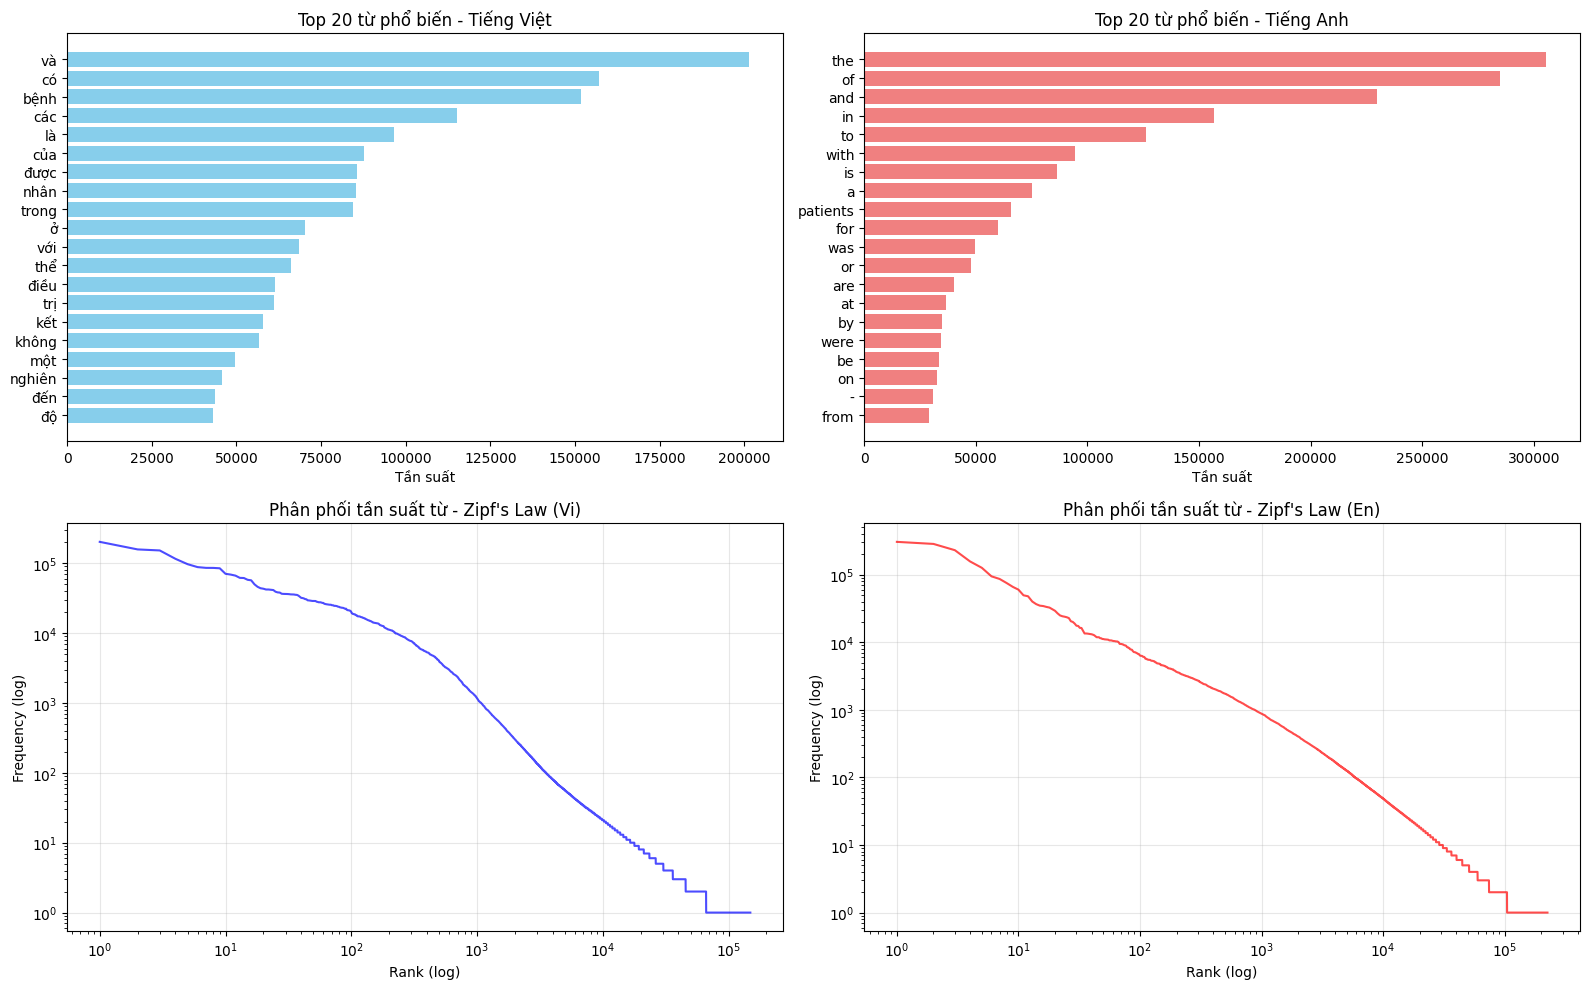


Vocab Coverage Analysis:
Số từ xuất hiện 1 lần (Vi): 82834 (55.5%)
Số từ xuất hiện 1 lần (En): 120527 (53.6%)
Số từ xuất hiện >=5 lần (Vi): 30289
Số từ xuất hiện >=5 lần (En): 50936


In [51]:
# Phân tích vocab
# Đếm tần suất từ trong corpus
src_word_freq = Counter()
for tokens in train_src_tokens:
    src_word_freq.update([t for t in tokens if t not in ['<SOS>', '<EOS>']])

tgt_word_freq = Counter()
for tokens in train_tgt_tokens:
    tgt_word_freq.update([t for t in tokens if t not in ['<SOS>', '<EOS>']])

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Top 20 từ phổ biến - Source
top_src = src_word_freq.most_common(20)
axes[0, 0].barh([w for w, _ in top_src][::-1], [c for _, c in top_src][::-1], color='skyblue')
axes[0, 0].set_title('Top 20 từ phổ biến - Tiếng Việt')
axes[0, 0].set_xlabel('Tần suất')

# Top 20 từ phổ biến - Target
top_tgt = tgt_word_freq.most_common(20)
axes[0, 1].barh([w for w, _ in top_tgt][::-1], [c for _, c in top_tgt][::-1], color='lightcoral')
axes[0, 1].set_title('Top 20 từ phổ biến - Tiếng Anh')
axes[0, 1].set_xlabel('Tần suất')

# Phân phối tần suất từ (log scale)
src_freqs = sorted(src_word_freq.values(), reverse=True)
tgt_freqs = sorted(tgt_word_freq.values(), reverse=True)

axes[1, 0].plot(range(1, len(src_freqs)+1), src_freqs, color='blue', alpha=0.7, label='Vi')
axes[1, 0].set_xscale('log')
axes[1, 0].set_yscale('log')
axes[1, 0].set_title('Phân phối tần suất từ - Zipf\'s Law (Vi)')
axes[1, 0].set_xlabel('Rank (log)')
axes[1, 0].set_ylabel('Frequency (log)')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(range(1, len(tgt_freqs)+1), tgt_freqs, color='red', alpha=0.7, label='En')
axes[1, 1].set_xscale('log')
axes[1, 1].set_yscale('log')
axes[1, 1].set_title('Phân phối tần suất từ - Zipf\'s Law (En)')
axes[1, 1].set_xlabel('Rank (log)')
axes[1, 1].set_ylabel('Frequency (log)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('vocab_distribution.png', dpi=150)
plt.show()

# Báo cáo vocab coverage
print(f"\nVocab Coverage Analysis:")
print(f"Số từ xuất hiện 1 lần (Vi): {sum(1 for f in src_word_freq.values() if f == 1)} ({sum(1 for f in src_word_freq.values() if f == 1)/len(src_word_freq)*100:.1f}%)")
print(f"Số từ xuất hiện 1 lần (En): {sum(1 for f in tgt_word_freq.values() if f == 1)} ({sum(1 for f in tgt_word_freq.values() if f == 1)/len(tgt_word_freq)*100:.1f}%)")
print(f"Số từ xuất hiện >=5 lần (Vi): {sum(1 for f in src_word_freq.values() if f >= 5)}")
print(f"Số từ xuất hiện >=5 lần (En): {sum(1 for f in tgt_word_freq.values() if f >= 5)}")

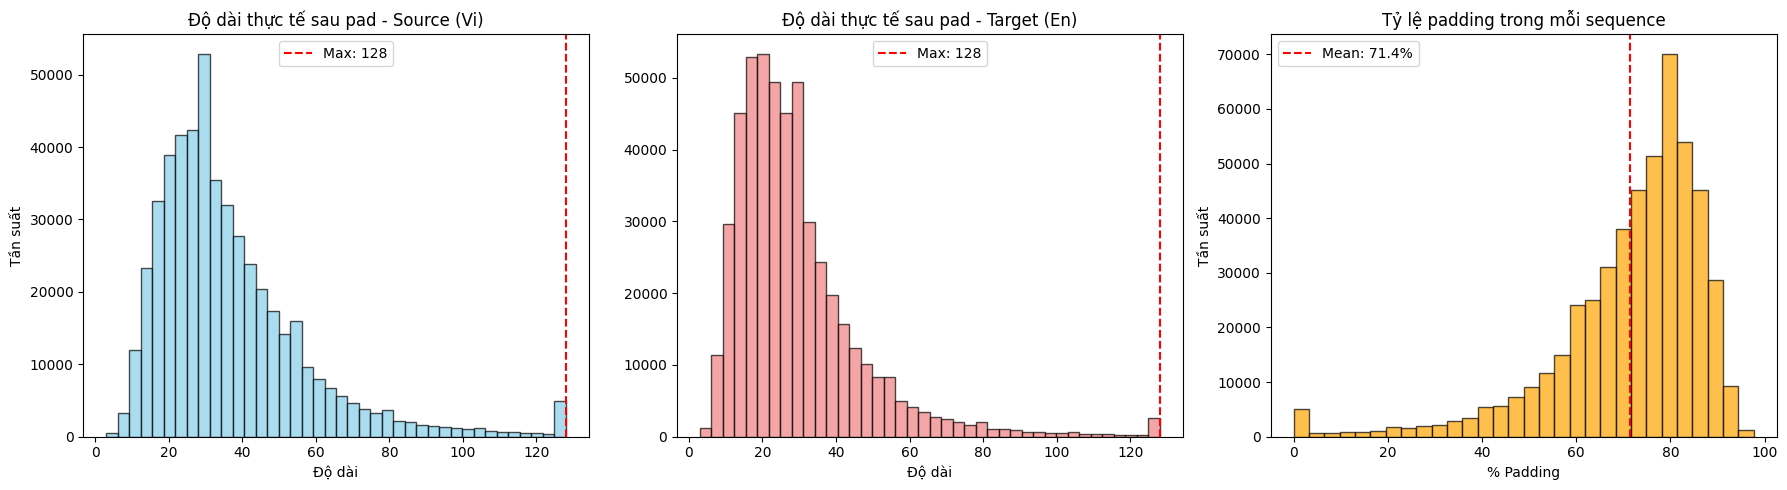

Số câu bị truncate (Vi): 4530
Số câu bị truncate (En): 2364
Tỷ lệ padding trung bình: 71.4%


In [52]:
# Phân tích sau khi pad/truncate
def get_actual_lengths(padded_tensor, pad_idx=0):
    """Tính độ dài thực (không tính padding)"""
    return [(row != pad_idx).sum().item() for row in padded_tensor]

train_src_actual_lens = get_actual_lengths(train_src_indices, pad_idx=src_pad_id)
train_tgt_actual_lens = get_actual_lengths(train_tgt_indices, pad_idx=tgt_pad_idx)
sequence_lengths = [max(s, t) for s, t in zip(train_src_actual_lens, train_tgt_actual_lens)]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Độ dài thực tế sau pad - Source
axes[0].hist(train_src_actual_lens, bins=40, color='skyblue', alpha=0.7, edgecolor='black')
axes[0].set_title('Độ dài thực tế sau pad - Source (Vi)')
axes[0].set_xlabel('Độ dài')
axes[0].set_ylabel('Tần suất')
axes[0].axvline(x=max_seq_len, color='red', linestyle='--', label=f'Max: {max_seq_len}')
axes[0].legend()

axes[1].hist(train_tgt_actual_lens, bins=40, color='lightcoral', alpha=0.7, edgecolor='black')
axes[1].set_title('Độ dài thực tế sau pad - Target (En)')
axes[1].set_xlabel('Độ dài')
axes[1].axvline(x=max_seq_len, color='red', linestyle='--', label=f'Max: {max_seq_len}')
axes[1].legend()

# Tỷ lệ padding
padding_ratios = [(max_seq_len - actual_len) / max_seq_len * 100 
                  for actual_len in train_src_actual_lens]
axes[2].hist(padding_ratios, bins=30, color='orange', alpha=0.7, edgecolor='black')
axes[2].set_title('Tỷ lệ padding trong mỗi sequence')
axes[2].set_xlabel('% Padding')
axes[2].set_ylabel('Tần suất')
axes[2].axvline(x=sum(padding_ratios)/len(padding_ratios), color='red', linestyle='--',
                label=f'Mean: {sum(padding_ratios)/len(padding_ratios):.1f}%')
axes[2].legend()

plt.tight_layout()
plt.savefig('padding_analysis.png', dpi=150)
plt.show()

print(f"Số câu bị truncate (Vi): {sum(1 for l in train_src_actual_lens if l >= max_seq_len)}")
print(f"Số câu bị truncate (En): {sum(1 for l in train_tgt_actual_lens if l >= max_seq_len)}")
print(f"Tỷ lệ padding trung bình: {sum(padding_ratios)/len(padding_ratios):.1f}%")

In [53]:
import copy
import math
from typing import Any, Callable, List, Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F

# -----------------------------
# Embeddings & Positional Enc
# -----------------------------
class InputEmbeddings(nn.Module):
    def __init__(self, d_model: int, vocab_size: int, padding_idx: Optional[int] = None):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=padding_idx)

    def forward(self, x: torch.LongTensor) -> torch.Tensor:
        # x: (batch, seq)
        return self.embedding(x) * math.sqrt(self.d_model)


class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.d_model = d_model

        pe = torch.zeros(max_len, d_model, dtype=torch.float32)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe, persistent=False)

    def forward(self, x: torch.Tensor, start_pos: int = 0) -> torch.Tensor:
        seq_len = x.size(1)
        # Use start_pos to slice the correct positions
        pe_slice = self.pe[:, start_pos : start_pos + seq_len, :].to(dtype=x.dtype, device=x.device)
        x = x + pe_slice
        return self.dropout(x)

In [54]:
class LayerNormalization(nn.Module):
    def __init__(self, features: int, eps: float = 1e-5, elementwise_affine: bool = True):
        super().__init__()
        self.eps = eps
        self.elementwise_affine = elementwise_affine
        if elementwise_affine:
            # keep names compatible with your checkpoints (alpha, bias)
            self.alpha = nn.Parameter(torch.ones(features))
            self.bias = nn.Parameter(torch.zeros(features))
        else:
            self.register_parameter("alpha", None)
            self.register_parameter("bias", None)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # compute moments in float32 for stability when x is fp16/bfloat16
        orig_dtype = x.dtype
        if orig_dtype in (torch.float16, torch.bfloat16):
            x_float = x.float()
        else:
            x_float = x

        mean = x_float.mean(dim=-1, keepdim=True)
        var = x_float.var(dim=-1, keepdim=True, unbiased=False)
        x_norm = (x_float - mean) / torch.sqrt(var + self.eps)

        if orig_dtype in (torch.float16, torch.bfloat16):
            x_norm = x_norm.to(orig_dtype)

        if self.elementwise_affine:
            alpha = self.alpha.to(x_norm.dtype).to(x_norm.device)
            bias = self.bias.to(x_norm.dtype).to(x_norm.device)
            return alpha * x_norm + bias
        return x_norm


class FeedForwardBlock(nn.Module):
    def __init__(
        self,
        model_dim: int,
        hidden_dim: int,
        dropout: float = 0.1,
        activation: Optional[Callable] = None,
        activation_name: Optional[str] = "gelu",
        final_dropout: Optional[float] = None,
    ):
        super().__init__()
        self.linear1 = nn.Linear(model_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, model_dim)
        self.dropout = nn.Dropout(dropout)
        self.final_dropout = nn.Dropout(dropout if final_dropout is None else final_dropout)

        if activation is not None:
            self.activation = activation
        else:
            name = (activation_name or "gelu").lower()
            if name == "gelu":
                self.activation = F.gelu
            elif name == "relu":
                self.activation = F.relu
            elif name in ("silu", "swish"):
                self.activation = F.silu
            else:
                raise ValueError(f"Unsupported activation: {name}")

        # sensible init
        nn.init.xavier_uniform_(self.linear1.weight)
        if self.linear1.bias is not None:
            nn.init.zeros_(self.linear1.bias)
        nn.init.xavier_uniform_(self.linear2.weight)
        if self.linear2.bias is not None:
            nn.init.zeros_(self.linear2.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = self.linear1(x)
        h = self.activation(h)
        h = self.dropout(h)
        out = self.linear2(h)
        out = self.final_dropout(out)
        return out

In [55]:
# -----------------------------
# Multi-Head Attention
# -----------------------------
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, num_heads: int, dropout: float = 0.1, bias: bool = True):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.w_q = nn.Linear(d_model, d_model, bias=bias)
        self.w_k = nn.Linear(d_model, d_model, bias=bias)
        self.w_v = nn.Linear(d_model, d_model, bias=bias)
        self.w_o = nn.Linear(d_model, d_model, bias=bias)
        self.dropout = nn.Dropout(dropout)
        self.scaling = 1.0 / math.sqrt(self.d_k)

    @staticmethod
    def _expand_for_heads(x: torch.Tensor, num_heads: int) -> torch.Tensor:
        b, seq_len, d_model = x.size()
        d_k = d_model // num_heads
        return x.view(b, seq_len, num_heads, d_k).transpose(1, 2)  # (b,h,seq,d_k)

    @staticmethod
    def _maybe_cast_for_softmax(t: torch.Tensor) -> Tuple[torch.Tensor, bool]:
        if t.dtype in (torch.float16, torch.bfloat16):
            t = t.float()
            return t, True
        return t, False

    def forward(
        self,
        q: torch.Tensor,
        k: torch.Tensor,
        v: torch.Tensor,
        attn_mask: Optional[torch.Tensor] = None,
        key_padding_mask: Optional[torch.Tensor] = None,
        need_weights: bool = False,
        past_key_value: Optional[Tuple[torch.Tensor, torch.Tensor]] = None,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Tuple[torch.Tensor, torch.Tensor]]:
        """
        q,k,v: (batch, seq, d_model)
        past_key_value: optional (k_cache, v_cache) with shape (batch, heads, seq_cached, d_k)
        returns: (output, attn_weights or None, present_key_value)
        """
        b, seq_q, _ = q.size()

        q_proj = self.w_q(q)
        k_proj = self.w_k(k)
        v_proj = self.w_v(v)

        qh = self._expand_for_heads(q_proj, self.num_heads)  # (b,h,seq_q,d_k)
        kh = self._expand_for_heads(k_proj, self.num_heads)  # (b,h,seq_k,d_k)
        vh = self._expand_for_heads(v_proj, self.num_heads)  # (b,h,seq_k,d_k)

        if past_key_value is not None:
            past_k, past_v = past_key_value                   # (b,h,seq_cached,d_k)
            kh = torch.cat([past_k, kh], dim=2)
            vh = torch.cat([past_v, vh], dim=2)
        present_key_value = (kh, vh)

        scores = torch.matmul(qh, kh.transpose(-2, -1)) * self.scaling  # (b,h,seq_q,seq_k)

        if key_padding_mask is not None:
            kpm = key_padding_mask.unsqueeze(1).unsqueeze(2)   # (b,1,1,seq_k)
            scores = scores.masked_fill(kpm, float('-inf'))

        if attn_mask is not None:
            # attn_mask: broadcast to (b,h,seq_q,seq_k)
            if attn_mask.dim() == 2:
                attn_mask = attn_mask.unsqueeze(0).unsqueeze(0)
            elif attn_mask.dim() == 3:
                attn_mask = attn_mask.unsqueeze(1)
            scores = scores.masked_fill(attn_mask, float('-inf'))

        scores_for_sm, was_cast = self._maybe_cast_for_softmax(scores)
        attn_weights = F.softmax(scores_for_sm, dim=-1)
        if was_cast:
            attn_weights = attn_weights.to(scores.dtype)

        attn_weights = self.dropout(attn_weights)
        attn_output = torch.matmul(attn_weights, vh)          # (b,h,seq_q,d_k)
        attn_output = attn_output.transpose(1, 2).contiguous().view(b, seq_q, self.d_model)
        out = self.w_o(attn_output)

        if not need_weights:
            attn_weights_out = None
        else:
            attn_weights_out = attn_weights.mean(dim=1)       # (b,seq_q,seq_k)

        return out, attn_weights_out, present_key_value


In [56]:
# -----------------------------
# Residual
# -----------------------------
class ResidualConnection(nn.Module):
    def __init__(self, d_model: int, dropout: float, eps: float = 1e-5):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = LayerNormalization(d_model, eps)

    def forward(self, x: torch.Tensor, sublayer_out: torch.Tensor) -> torch.Tensor:
        # pre-norm is handled by caller: caller will compute sublayer_out using self.norm(x)
        return x + self.dropout(sublayer_out)

In [57]:
# -----------------------------
# Layers
# -----------------------------
class EncoderLayer(nn.Module):
    def __init__(self, d_model: int, h: int, d_ff: int, dropout: float):
        super().__init__()
        self.self_attention_block = MultiHeadAttention(d_model, h, dropout)
        self.feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        self.residual_connections = nn.ModuleList([
            ResidualConnection(d_model, dropout),
            ResidualConnection(d_model, dropout),
        ])

    def forward(
        self,
        x: torch.Tensor,
        src_attn_mask: Optional[torch.Tensor] = None,
        src_key_padding_mask: Optional[torch.Tensor] = None,
        need_weights: bool = False,
    ):
        # self\-attention
        norm_x = self.residual_connections[0].norm(x)
        attn_out, attn_w, _ = self.self_attention_block(
            norm_x,
            norm_x,
            norm_x,
            attn_mask=src_attn_mask,
            key_padding_mask=src_key_padding_mask,
            need_weights=need_weights,
            past_key_value=None,
        )
        x = self.residual_connections[0](x, attn_out)

        # feed\-forward
        norm_x = self.residual_connections[1].norm(x)
        ff_out = self.feed_forward_block(norm_x)
        x = self.residual_connections[1](x, ff_out)

        if need_weights:
            return x, attn_w
        return x


class DecoderLayer(nn.Module):
    def __init__(self, d_model: int, h: int, d_ff: int, dropout: float):
        super().__init__()
        self.self_attention_block = MultiHeadAttention(d_model, h, dropout)
        self.cross_attention_block = MultiHeadAttention(d_model, h, dropout)
        self.feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        self.residual_connections = nn.ModuleList([
            ResidualConnection(d_model, dropout),
            ResidualConnection(d_model, dropout),
            ResidualConnection(d_model, dropout),
        ])

    def forward(
        self,
        x: torch.Tensor,
        encoder_output: torch.Tensor,
        tgt_attn_mask: Optional[torch.Tensor] = None,
        memory_attn_mask: Optional[torch.Tensor] = None,
        tgt_key_padding_mask: Optional[torch.Tensor] = None,
        memory_key_padding_mask: Optional[torch.Tensor] = None,
        need_weights: bool = False,
        past_self_kv: Optional[Tuple[torch.Tensor, torch.Tensor]] = None,
    ):
        # self-attn with cache
        norm_x = self.residual_connections[0].norm(x)
        self_attn_out, self_attn_w, present_self_kv = self.self_attention_block(
            norm_x, norm_x, norm_x,
            attn_mask=tgt_attn_mask,
            key_padding_mask=tgt_key_padding_mask,
            need_weights=need_weights,
            past_key_value=past_self_kv,
        )
        x = self.residual_connections[0](x, self_attn_out)

        # cross-attn (no cache)
        norm_x = self.residual_connections[1].norm(x)
        cross_attn_out, cross_attn_w, _ = self.cross_attention_block(
            norm_x, encoder_output, encoder_output,
            attn_mask=memory_attn_mask,
            key_padding_mask=memory_key_padding_mask,
            need_weights=need_weights,
            past_key_value=None,
        )
        x = self.residual_connections[1](x, cross_attn_out)

        # FFN
        norm_x = self.residual_connections[2].norm(x)
        ff_out = self.feed_forward_block(norm_x)
        x = self.residual_connections[2](x, ff_out)

        if need_weights:
            return x, self_attn_w, cross_attn_w, present_self_kv
        return x, None, None, present_self_kv

In [58]:
# -----------------------------
# Encoder / Decoder stacks + Projection + Transformer
# -----------------------------

class Encoder(nn.Module):
    def __init__(self, layers: List[nn.Module], d_model: int):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.norm = LayerNormalization(d_model)

    def forward(
        self,
        x: torch.Tensor,
        src_attn_mask: Optional[torch.Tensor] = None,
        src_key_padding_mask: Optional[torch.Tensor] = None,
        need_weights: bool = False,
    ):
        attn_weights_all = [] if need_weights else None

        for layer in self.layers:
            if need_weights:
                x, attn = layer(
                    x,
                    src_attn_mask=src_attn_mask,
                    src_key_padding_mask=src_key_padding_mask,
                    need_weights=True,
                )
                attn_weights_all.append(attn)
            else:
                x = layer(
                    x,
                    src_attn_mask=src_attn_mask,
                    src_key_padding_mask=src_key_padding_mask,
                    need_weights=False,
                )

        x = self.norm(x)
        if need_weights:
            return x, attn_weights_all
        return x


class Decoder(nn.Module):
    def __init__(self, layers: List[nn.Module], d_model: int):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.norm = LayerNormalization(d_model)

    def forward(
        self,
        x: torch.Tensor,
        encoder_output: torch.Tensor,
        tgt_attn_mask: Optional[torch.Tensor] = None,
        memory_attn_mask: Optional[torch.Tensor] = None,
        tgt_key_padding_mask: Optional[torch.Tensor] = None,
        memory_key_padding_mask: Optional[torch.Tensor] = None,
        need_weights: bool = False,
        past_kv: Optional[List[Tuple[torch.Tensor, torch.Tensor]]] = None,
    ):
        self_attn_all = [] if need_weights else None
        cross_attn_all = [] if need_weights else None
        present_kv = []

        for i, layer in enumerate(self.layers):
            layer_past = None if past_kv is None else past_kv[i]
            x, self_w, cross_w, layer_present_kv = layer(
                x,
                encoder_output,
                tgt_attn_mask=tgt_attn_mask,
                memory_attn_mask=memory_attn_mask,
                tgt_key_padding_mask=tgt_key_padding_mask,
                memory_key_padding_mask=memory_key_padding_mask,
                need_weights=need_weights,
                past_self_kv=layer_past,
            )
            present_kv.append(layer_present_kv)
            if need_weights:
                self_attn_all.append(self_w)
                cross_attn_all.append(cross_w)

        x = self.norm(x)
        if need_weights:
            return x, self_attn_all, cross_attn_all, present_kv
        return x, present_kv


class ProjectionLayer(nn.Module):
    def __init__(self, d_model: int, vocab_size: int, bias: bool = True, apply_log_softmax: bool = False):
        super().__init__()
        self.proj = nn.Linear(d_model, vocab_size, bias=bias)
        self.apply_log_softmax = apply_log_softmax

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        logits = self.proj(x)
        if self.apply_log_softmax:
            return torch.log_softmax(logits, dim=-1)
        return logits

    def tie_to_embedding(self, embedding_module: nn.Embedding):
        if not isinstance(embedding_module, nn.Embedding):
            raise TypeError("embedding_module must be nn.Embedding")
        # Share weight (Parameter)
        self.proj.weight = embedding_module.weight
        return self


class Transformer(nn.Module):
    def __init__(
        self,
        encoder: Encoder,
        decoder: Decoder,
        src_embed: nn.Module,
        tgt_embed: nn.Module,
        src_pos: nn.Module,
        tgt_pos: nn.Module,
        projection_layer: ProjectionLayer,
    ):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.projection_layer = projection_layer

    def encode(
        self,
        src: torch.Tensor,
        src_attn_mask: Optional[torch.Tensor] = None,
        src_key_padding_mask: Optional[torch.Tensor] = None,
        need_weights: bool = False,
    ):
        x = self.src_embed(src)
        x = self.src_pos(x)
        return self.encoder(x, src_attn_mask=src_attn_mask, src_key_padding_mask=src_key_padding_mask, need_weights=need_weights)

    # New explicit API
    def decode(
        self,
        encoder_output: torch.Tensor,
        tgt: torch.Tensor,
        tgt_attn_mask: Optional[torch.Tensor] = None,
        memory_attn_mask: Optional[torch.Tensor] = None,
        tgt_key_padding_mask: Optional[torch.Tensor] = None,
        memory_key_padding_mask: Optional[torch.Tensor] = None,
        need_weights: bool = False,
        past_kv: Optional[List[Tuple[torch.Tensor, torch.Tensor]]] = None,
    ):
        y = self.tgt_embed(tgt)
        y = self.tgt_pos(y)
        if need_weights:
            dec_out, self_w, cross_w, present_kv = self.decoder(
                y,
                encoder_output,
                tgt_attn_mask=tgt_attn_mask,
                memory_attn_mask=memory_attn_mask,
                tgt_key_padding_mask=tgt_key_padding_mask,
                memory_key_padding_mask=memory_key_padding_mask,
                need_weights=True,
                past_kv=past_kv,
            )
            return dec_out, self_w, cross_w, present_kv
        else:
            dec_out, present_kv = self.decoder(
                y,
                encoder_output,
                tgt_attn_mask=tgt_attn_mask,
                memory_attn_mask=memory_attn_mask,
                tgt_key_padding_mask=tgt_key_padding_mask,
                memory_key_padding_mask=memory_key_padding_mask,
                past_kv=past_kv,
            )
            return dec_out, present_kv

    def project(self, x: torch.Tensor) -> torch.Tensor:
        return self.projection_layer(x)

In [59]:
# -----------------------------
# helpers: clone / build / masks
# -----------------------------
def clones_deep(module: nn.Module, N: int) -> nn.ModuleList:
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


def build_transformer(
    src_vocab_size: int,
    tgt_vocab_size: int,
    src_max_len: int,
    tgt_max_len: int,
    d_model: int = 512,
    N: int = 6,
    h: int = 8,
    dropout: float = 0.1,
    d_ff: int = 2048,
    src_padding_idx: int = 0,
    tgt_padding_idx: int = 0,
    tie_weights: bool = True,
) -> Transformer:
    src_embed = InputEmbeddings(d_model=d_model, vocab_size=src_vocab_size, padding_idx=src_padding_idx)
    tgt_embed = InputEmbeddings(d_model=d_model, vocab_size=tgt_vocab_size, padding_idx=tgt_padding_idx)
    src_pos = PositionalEncoding(d_model=d_model, max_len=src_max_len, dropout=dropout)
    tgt_pos = PositionalEncoding(d_model=d_model, max_len=tgt_max_len, dropout=dropout)

    enc_proto = EncoderLayer(d_model=d_model, h=h, d_ff=d_ff, dropout=dropout)
    dec_proto = DecoderLayer(d_model=d_model, h=h, d_ff=d_ff, dropout=dropout)

    encoder = Encoder(clones_deep(enc_proto, N), d_model=d_model)
    decoder = Decoder(clones_deep(dec_proto, N), d_model=d_model)

    proj = ProjectionLayer(d_model=d_model, vocab_size=tgt_vocab_size, apply_log_softmax=False)
    model = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, proj)

    # init: xavier for linear weights
    for name, p in model.named_parameters():
        if p.requires_grad:
            if p.ndim > 1:
                nn.init.xavier_uniform_(p)
            else:
                if "bias" in name:
                    nn.init.zeros_(p)

    # tie weights
    if tie_weights:
        # target embedding may be wrapper
        emb = getattr(tgt_embed, "embedding", tgt_embed)
        if isinstance(emb, nn.Embedding):
            proj.tie_to_embedding(emb)
        else:
            raise TypeError("Unable to tie weights: tgt_embed has no nn.Embedding accessible as .embedding")

    return model


# Mask helpers (new API)
def make_padding_key_mask(seq: torch.Tensor, pad_idx: int = 0) -> torch.Tensor:
    # returns (batch, seq) bool True==padding
    return (seq == pad_idx)


def make_causal_attn_mask(seq_len: int, device: Optional[torch.device] = None) -> torch.Tensor:
    # returns (seq_len, seq_len) bool True==masked (upper triangle above diagonal)
    mask = torch.triu(torch.ones((seq_len, seq_len), device=device, dtype=torch.bool), diagonal=1)
    return mask


def combine_target_masks(tgt_seq: torch.Tensor, pad_idx: int = 0) -> Tuple[torch.Tensor, torch.Tensor]:
    # returns (tgt_attn_mask (seq,seq), tgt_key_padding_mask (batch, seq))
    tgt_seq_len = tgt_seq.size(1)
    tgt_attn_mask = make_causal_attn_mask(tgt_seq_len, device=tgt_seq.device)
    tgt_key_padding_mask = make_padding_key_mask(tgt_seq, pad_idx=pad_idx)
    return tgt_attn_mask, tgt_key_padding_mask


def create_masks(src: torch.Tensor, tgt: torch.Tensor, pad_idx: int = 0) -> Tuple[
    torch.Tensor, torch.Tensor, torch.Tensor]:
    # returns (src_key_padding_mask, tgt_attn_mask, tgt_key_padding_mask)
    src_key_padding_mask = make_padding_key_mask(src, pad_idx=pad_idx)
    tgt_attn_mask, tgt_key_padding_mask = combine_target_masks(tgt, pad_idx=pad_idx)
    return src_key_padding_mask, tgt_attn_mask, tgt_key_padding_mask


def create_masks_legacy(src: torch.Tensor, tgt: torch.Tensor, pad_idx: int = 0) -> Tuple[torch.Tensor, torch.Tensor]:
    # backward-compatible shapes: (batch,1,1,src_seq), (batch,1,tgt_seq,tgt_seq)
    src_kpm = make_padding_key_mask(src, pad_idx=pad_idx)  # (batch, src_seq) True==pad
    src_padding_broadcast = src_kpm.unsqueeze(1).unsqueeze(2)  # (batch,1,1,src_seq)

    tgt_attn = make_causal_attn_mask(tgt.size(1), device=tgt.device)  # (tgt_seq, tgt_seq)
    tgt_kpm = make_padding_key_mask(tgt, pad_idx=pad_idx)  # (batch, tgt_seq)
    causal_b = tgt_attn.unsqueeze(0).unsqueeze(0).to(device=tgt.device)  # (1,1,tgt_seq,tgt_seq)
    padding_b = tgt_kpm.unsqueeze(1).unsqueeze(-1)  # (batch,1,tgt_seq,1)
    tgt_combined = causal_b | padding_b  # (batch,1,tgt_seq,tgt_seq)
    return src_padding_broadcast, tgt_combined

In [60]:
def indices_to_tokens(indices: torch.Tensor, vocab: Dict[str, int]) -> List[str]:
    inv_vocab = {idx: token for token, idx in vocab.items()}
    return [inv_vocab.get(idx.item(), '<UNK>') for idx in indices]


def detokenize(tokens: List[str]) -> str:
    filtered = [tok for tok in tokens if tok not in {'<SOS>', '<EOS>', '<PAD>'}]
    return ' '.join(filtered)

def indices_to_text(tokenizer, indices):
    # Convert tensor to list
    if isinstance(indices, torch.Tensor):
        indices = indices.tolist()
        
    # Decode (skip_special_tokens=True removes SOS, EOS, PAD automatically)
    return tokenizer.decode(indices, skip_special_tokens=True)


use_cuda = torch.cuda.is_available() and torch.cuda.device_count() > 0
if use_cuda:
    current_device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(current_device)
    print(f"⚡ Using CUDA device {current_device}: {device_name}")
else:
    print("⚠️ CUDA unavailable, running on CPU.")
device = torch.device('cuda' if use_cuda else 'cpu')
model_config = {
    'src_vocab_size': src_tokenizer.get_vocab_size(),
    'tgt_vocab_size': tgt_tokenizer.get_vocab_size(),
    
    'src_max_len': max_seq_len,
    'tgt_max_len': max_seq_len,
    
    'd_model': 512,
    'N': 6,
    'h': 8,
    'dropout': 0.1,
    'd_ff': 2048,
    
    'src_padding_idx': src_tokenizer.token_to_id("<PAD>"),
    'tgt_padding_idx': tgt_tokenizer.token_to_id("<PAD>"),
    'tie_weights': True,
}
model = build_transformer(**model_config).to(device)
if use_cuda and not next(model.parameters()).is_cuda:
    raise RuntimeError("CUDA requested but model parameters remain on CPU.")

⚡ Using CUDA device 0: Tesla P100-PCIE-16GB


In [61]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, label_smoothing: float, vocab_size: int, ignore_index: int):
        super().__init__()
        if not 0.0 <= label_smoothing < 1.0:
            raise ValueError("label_smoothing must be in [0, 1)")
        self.smoothing = label_smoothing
        self.vocab_size = vocab_size
        self.ignore_index = ignore_index
        self.confidence = 1.0 - label_smoothing

    def forward(self, logits: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        log_probs = F.log_softmax(logits, dim=-1)
        target = target.view(-1)
        log_probs = log_probs.view(-1, log_probs.size(-1))
        with torch.no_grad():
            true_dist = torch.full_like(log_probs, self.smoothing / (log_probs.size(-1) - 1))
            target_clamped = target.clone()
            ignore_mask = target_clamped == self.ignore_index
            target_clamped = target_clamped.masked_fill(ignore_mask, 0)
            true_dist.scatter_(1, target_clamped.unsqueeze(1), self.confidence)
            true_dist.masked_fill_(ignore_mask.unsqueeze(1), 0.0)
        loss = torch.sum(-true_dist * log_probs, dim=-1)
        loss = loss.masked_fill(ignore_mask, 0.0)
        denom = (~ignore_mask).sum().clamp_min(1)
        return loss.sum() / denom


class WarmupInverseSqrtScheduler(torch.optim.lr_scheduler._LRScheduler):
    def __init__(
        self,
        optimizer: torch.optim.Optimizer,
        model_dim: int,
        warmup_steps: int = 4000,
        factor: float = 1.0,
        last_epoch: int = -1,
    ):
        self.model_dim = model_dim
        self.warmup_steps = max(1, warmup_steps)
        self.factor = factor
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        step = max(self._step_count, 1)
        scale = self.factor * (self.model_dim ** -0.5) * min(step ** -0.5, step * (self.warmup_steps ** -1.5))
        return [scale for _ in self.base_lrs]

In [62]:

# 2. Re-initialize Criterion
criterion = LabelSmoothingLoss(
    label_smoothing=0.1, 
    vocab_size=tgt_tokenizer.get_vocab_size(), # Correct size
    ignore_index=tgt_pad_idx
)

# 3. Re-initialize Optimizer (Required because model params are new)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.01)

# 4. Re-initialize Scheduler (Required because d_model changed)
scheduler = WarmupInverseSqrtScheduler(
    optimizer,
    model_dim=model_config['d_model'],
    warmup_steps=4000,
    factor=1.0,
)

scaler = torch.cuda.amp.GradScaler(enabled=use_cuda)

/tmp/ipykernel_47/3301200846.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_cuda)


In [63]:
def shift_targets(tgt_batch: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    tgt_input = tgt_batch[:, :-1]
    tgt_output = tgt_batch[:, 1:]
    return tgt_input, tgt_output


def forward_step(model: nn.Module, src_batch: torch.Tensor, tgt_input: torch.Tensor) -> torch.Tensor:
    src_batch = src_batch.to(device)
    tgt_input = tgt_input.to(device)

    src_kpm = make_padding_key_mask(src_batch, pad_idx=src_pad_idx)
    tgt_attn_mask = make_causal_attn_mask(tgt_input.size(1), device=device)
    tgt_kpm = make_padding_key_mask(tgt_input, pad_idx=tgt_pad_idx)

    memory = model.encode(src_batch, src_key_padding_mask=src_kpm)
    
    decoder_out, _ = model.decode(
        memory,
        tgt_input,
        tgt_attn_mask=tgt_attn_mask,
        tgt_key_padding_mask=tgt_kpm,
        memory_key_padding_mask=src_kpm,
    )
    
    logits = model.project(decoder_out)
    return logits


gradient_accum_steps = 4


def train_one_epoch(model: nn.Module, data_loader: DataLoader) -> float:
    model.train()
    total_loss = 0.0
    total_tokens = 0
    progress = tqdm(data_loader, desc="Train", leave=False)
    optimizer.zero_grad(set_to_none=True)
    for step, (src_batch, tgt_batch) in enumerate(progress, start=1):
        src_batch = src_batch.to(device)
        tgt_batch = tgt_batch.to(device)
        tgt_input, tgt_output = shift_targets(tgt_batch)
        with torch.amp.autocast(device_type='cuda', enabled=use_cuda):
            logits = forward_step(model, src_batch, tgt_input)
            loss = criterion(logits.reshape(-1, logits.size(-1)), tgt_output.reshape(-1))
            loss = loss / gradient_accum_steps
        scaler.scale(loss).backward()

        if step % gradient_accum_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()

        batch_tokens = (tgt_output != tgt_pad_idx).sum().item()
        total_loss += loss.item() * gradient_accum_steps * batch_tokens
        total_tokens += batch_tokens
        progress.set_postfix(loss=loss.item() * gradient_accum_steps, lr=optimizer.param_groups[0]['lr'])

    if (step % gradient_accum_steps) != 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    return total_loss / max(total_tokens, 1)


def evaluate(model: nn.Module, data_loader: DataLoader) -> float:
    model.eval()
    total_loss = 0.0
    total_tokens = 0
    with torch.no_grad():
        for src_batch, tgt_batch in data_loader:
            src_batch = src_batch.to(device)
            tgt_batch = tgt_batch.to(device)
            tgt_input, tgt_output = shift_targets(tgt_batch)
            logits = forward_step(model, src_batch, tgt_input)
            loss = criterion(logits.reshape(-1, logits.size(-1)), tgt_output.reshape(-1))
            batch_tokens = (tgt_output != tgt_pad_idx).sum().item()
            total_loss += loss.item() * batch_tokens
            total_tokens += batch_tokens
    return total_loss / max(total_tokens, 1)


In [ ]:
num_epochs = 30
best_val_loss = float('inf')
history = {'train_loss': [], 'val_loss': [], 'val_ppl': []}
checkpoint_dir = Path('checkpoints')
checkpoint_dir.mkdir(exist_ok=True)

for epoch in range(1, num_epochs + 1):
    start = time.time()
    train_loss = train_one_epoch(model, train_loader)
    val_loss = evaluate(model, val_loader)
    val_ppl = math.exp(min(val_loss, 20))  # cap to avoid inf

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_ppl'].append(val_ppl)

    epoch_time = time.time() - start
    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_ppl={val_ppl:.2f} | time={epoch_time:.1f}s")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({'model_state_dict': model.state_dict(), 'config': model_config, 'epoch': epoch}, checkpoint_dir / 'best_transformer.pt')
        print("  ↳ Saved new best checkpoint")

Train:   0%|          | 0/14063 [00:00<?, ?it/s]

In [ ]:
def greedy_decode(
    model: Transformer,
    src_seq: torch.Tensor,
    max_len: int,
    pad_idx: int,
    sos_idx: int,
    eos_idx: int,
) -> torch.Tensor:
    model.eval()
    src_seq = src_seq.unsqueeze(0).to(device)  # (1, src_len)
    src_kpm = make_padding_key_mask(src_seq, pad_idx=pad_idx)
    memory = model.encode(src_seq, src_key_padding_mask=src_kpm)  # (1, src_len, d_model)

    ys = torch.full((1, 1), sos_idx, dtype=torch.long, device=device)
    finished = False
    past_kv = None  # list of (k,v) per layer

    for _ in range(max_len - 1):
        tgt_attn_mask = None  # with KV cache, causal is enforced by cache order
        tgt_kpm = make_padding_key_mask(ys, pad_idx=pad_idx)

        dec_out, past_kv = model.decode(
            memory,
            ys[:, -1:],                     # only latest token
            tgt_attn_mask=tgt_attn_mask,
            tgt_key_padding_mask=tgt_kpm[:, -1:],
            memory_key_padding_mask=src_kpm,
            past_kv=past_kv,
        )
        logits = model.project(dec_out[:, -1])      # (1, vocab)
        next_token = logits.argmax(dim=-1, keepdim=True)  # (1,1)

        ys = torch.cat([ys, next_token], dim=1)
        if next_token.item() == eos_idx:
            finished = True
            break

    if not finished:
        ys = ys
    return ys.squeeze(0)

def beam_search_decode(
    model: Transformer,
    src_seq: torch.Tensor,
    max_len: int,
    pad_idx: int,
    sos_idx: int,
    eos_idx: int,
    beam_size: int = 4,
    length_penalty: float = 0.6,
) -> torch.Tensor:
    model.eval()
    src_seq = src_seq.unsqueeze(0).to(device)  # (1, src_len)
    src_kpm = make_padding_key_mask(src_seq, pad_idx=pad_idx)
    memory = model.encode(src_seq, src_key_padding_mask=src_kpm)

    init_seq = torch.full((1, 1), sos_idx, dtype=torch.long, device=device)
    beams = [(init_seq, 0.0, None)]  # (seq, log_prob, past_kv)
    completed = []

    for step in range(max_len - 1):
        new_beams = []
        for seq, log_p, past_kv in beams:
            if seq[0, -1].item() == eos_idx:
                completed.append((seq, log_p))
                continue

            tgt_kpm = make_padding_key_mask(seq, pad_idx=pad_idx)
            dec_out, new_past_kv = model.decode(
                memory,
                seq[:, -1:],                         # last token
                tgt_attn_mask=None,
                tgt_key_padding_mask=tgt_kpm[:, -1:],
                memory_key_padding_mask=src_kpm,
                past_kv=past_kv,
            )
            logits = model.project(dec_out[:, -1])    # (1, vocab)
            log_probs = F.log_softmax(logits, dim=-1).squeeze(0)  # (vocab,)

            topk_log_probs, topk_ids = torch.topk(log_probs, beam_size)
            for k in range(beam_size):
                next_id = topk_ids[k].unsqueeze(0).unsqueeze(0)  # (1,1)
                next_seq = torch.cat([seq, next_id], dim=1)
                next_log_p = log_p + topk_log_probs[k].item()
                new_beams.append((next_seq, next_log_p, new_past_kv))

        if not new_beams:
            break

        new_beams.sort(key=lambda x: x[1], reverse=True)
        beams = new_beams[:beam_size]

    completed.extend([(seq, log_p) for seq, log_p, _ in beams if seq[0, -1].item() == eos_idx])
    if not completed:
        best_seq, _ = max(beams, key=lambda x: x[1])[:2]
        return best_seq.squeeze(0)

    def lp(length):
        return ((5 + length) / 6) ** length_penalty

    best_seq, best_score = max(
        completed,
        key=lambda x: x[1] / lp(x[0].size(1)),
    )
    return best_seq.squeeze(0)

In [ ]:
def evaluate_bleu(
    model: Transformer,
    data_loader: DataLoader,
    max_len: int = 128,
    beam_size: int = 4,
    use_beam: bool = False,
) -> Dict[str, float]:
    model.eval()
    references = []
    hypotheses = []
    smoothing_fn = SmoothingFunction().method4

    with torch.no_grad():
        for src_batch, tgt_batch in tqdm(data_loader, desc="BLEU eval", leave=False):
            if use_beam:
                decoded = [
                    beam_search_decode(model, src_seq, max_len, tgt_pad_idx, sos_idx, eos_idx, beam_size)
                    for src_seq in src_batch
                ]
            else:
                decoded = batch_greedy_decode(model, src_batch, max_len, tgt_pad_idx, sos_idx, eos_idx)

            for hyp_tokens, tgt_seq in zip(decoded, tgt_batch):
                hyp_sentence = indices_to_text(hyp_tokens, tgt_vocab)
                ref_sentence = indices_to_text(tgt_seq, tgt_vocab)
                if hyp_sentence:
                    hypotheses.append(hyp_sentence.split())
                    references.append([ref_sentence.split()])
    bleu = corpus_bleu(references, hypotheses, smoothing_function=smoothing_fn)
    return {'BLEU': bleu * 100, 'refs': references, 'hyps': hypotheses}

# After training
bleu_results = evaluate_bleu(model, val_loader, max_len=max_seq_len, beam_size=4)
val_bleu = bleu_results['BLEU']
print(f"Validation BLEU: {val_bleu:.2f}")



In [ ]:
def describe_model_size(model: nn.Module) -> None:
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    bytes_fp32 = total * 4  # float32 params occupy 4 bytes
    print(f"Total params: {total:,}")
    print(f"Trainable params: {trainable:,}")
    print(f"≈{bytes_fp32 / (1024 ** 2):.1f} MB if stored in fp32 weights")


describe_model_size(model)